In [1]:
import pandas as pd
import numpy as np
import spacy
import nltk
# nltk.download('stopwords')
# nltk.download('wordnet')
from nltk.tokenize import word_tokenize
import matplotlib.pyplot as plt
import seaborn as sns
import string
import re
from bs4 import BeautifulSoup
from html import unescape

[nltk_data] Downloading package stopwords to /home/mohsen/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/mohsen/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
train = pd.read_csv("Corona_NLP_train.csv")
test = pd.read_csv("Corona_NLP_test.csv")
data = pd.concat([train, test])

In [3]:
def makeClean(text):
    #Removing escaped tags if there is any
    text = BeautifulSoup(unescape(text), 'lxml').text
    #Removing the url links
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    #Removing the html tags
    text = re.sub(r'<.*?>', '', text)
    
    #Removing mentions
    text = re.sub(r'@\w+','',text)
    #Removing hashtags
    text=re.sub(r'#\w+','',text)
    
    #Lowercasing the text 
    text = text.lower()
    #Removing numbers
    text = re.sub(r"(?<=\d)(st|nd|rd|th)\b", '', text)
    text = re.sub('[0-9]+', '', text)
    
    #Converting the contractions into their corresponding standard form 
    text = re.sub(r"won't", "will not", text)
    text = re.sub(r"can\'t", "can not", text)
    text = re.sub(r"don't", "do not", text)
    text = re.sub(r"don t", "do not", text)
    text = re.sub(r"doesn't", "does not", text)
    text = re.sub(r"n\'t", " not", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'s", " is", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'t", " not", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'m", " am", text)

   
    #Removing punctuation
    for char in text:
        if char in string.punctuation:
            text=text.replace(char, '')
    #Remiving the extra spaces
    text = re.sub(r"\s+"," ",text).strip()
    
    return(text)


# Tokenizing the data using NLTK package
stopwords = nltk.corpus.stopwords.words('english')

# def nltkPreprocess(text):
# #     stemmer = nltk.PorterStemmer()
#     lemmatizer = nltk.WordNetLemmatizer()
#     tokens = word_tokenize(text)
# #     tokens = [stemmer.stem(token) for token in tokens if token not in stopwords]
    
#     return [lemmatizer.lemmatize(token) for token in tokens if token not in stopwords]


# #Tokenizing the data using spacy package

# nlp = spacy.load("en_core_web_sm")
# def spacyPreprocess(text):
#     doc = nlp(text)
#     return [token.lemma_ for token in doc if token.lemma_.isalpha() and not token.is_stop]

def nltkPreprocess(text):
#     stemmer = nltk.PorterStemmer()
    lemmatizer = nltk.WordNetLemmatizer()
    tokens = word_tokenize(text)
#     tokens = [stemmer.stem(token) for token in tokens if token not in stopwords]
    tokensList = ' '.join(lemmatizer.lemmatize(token) for token in tokens if token not in stopwords)
    return str(tokensList).strip('[]')
#     return tokensList


#Tokenizing the data using spacy package

nlp = spacy.load("en_core_web_sm")
def spacyPreprocess(text):
    doc = nlp(text)
    tokensList = " ".join(token.lemma_ for token in doc if token.lemma_.isalpha() and not token.is_stop)
#     return str(tokensList).strip('[]')
    return tokensList

In [4]:
import warnings
warnings.filterwarnings('ignore')

#Applying the cleaning function on the original tweets

data["CleanedTweet"] = data["OriginalTweet"].map(lambda text: makeClean(text))



#Tokenizing by spacy
data["Tokenized_Spacy"] = data["CleanedTweet"].map(lambda text:spacyPreprocess(text))

#Tokenizing by NLTK
# eda_data["Tokenized_nltk"] = eda_data["CleanedTweet"].map(lambda text:nltkPreprocess(text))

In [5]:
#Inserting the Sentiment column into the new data frame. A 3-class Sentiment column was also created to have Negative, Neutral, and Positive classes.

data["Sentiment2"]= data["Sentiment"].map({"Neutral":"Neutral", "Positive":"Positive", "Negative":"Negative", "Extremely Negative":"Negative", "Extremely Positive":"Positive"})


In [6]:
from sklearn.model_selection import train_test_split
classCol = 'Sentiment2'
train,test = train_test_split(data, test_size=0.15, stratify=data[classCol], random_state=41)
X_train, y_train = train['Tokenized_Spacy'], train[classCol]
X_test, y_test = test["Tokenized_Spacy"], test[classCol]

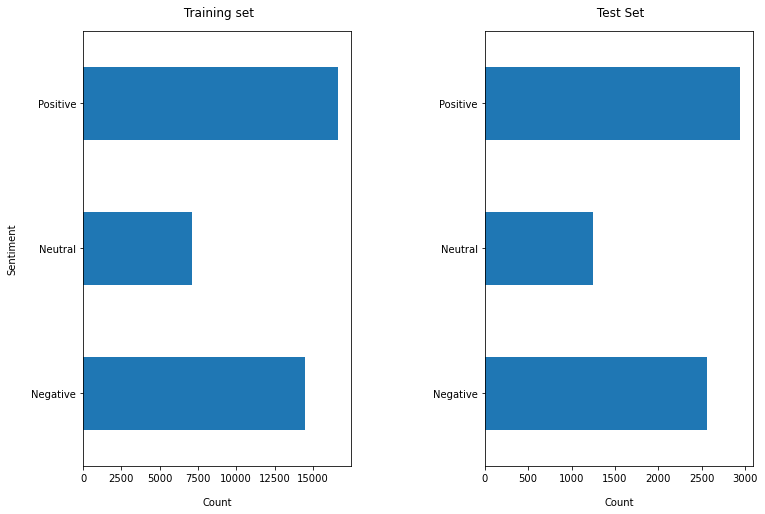

In [7]:
# import matplotlib.pyplot as plt
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(12,8), )
train['Sentiment2'].value_counts().sort_index().plot(kind='barh', ax=ax1)

ax1.set_xlabel("Count", labelpad=14)
ax1.set_ylabel("Sentiment", labelpad=14)
ax1.set_title(" Training set", y=1.02);


test['Sentiment2'].value_counts().sort_index().plot(kind='barh', ax=ax2)
ax2.set_xlabel("Count", labelpad=14)

ax2.set_title(" Test Set", y=1.02);

plt.subplots_adjust(wspace=0.5)

# Vectorization

In order to make a text document learnable by a machine learning algorithm, it first must be converted to a numeric representation since the machine learning algorithms operate on numeric input spaces. Therefore, we need to represent the obtained tokens as the numeric arrays so that it is possible to perform a machine learning on them. This process is reffered to as text vectorization or feature extraction and is an essential step before applying any machine learning algorithm.
There are different approaches to transform a text document into a numeric vector from which the Bag-of-words (BOW) was implemented in this work.

With BOW approach, a document is simply vectorized numerically in such a way that the length of the vector is the number of words or tokens included in the document. In other words each of the tokens will be a feature in this bag and it must be assigned a numeric value which represents the corresponding word numerically. There exist several choices to compute those numeric representations among which $frequency, TF–IDF$ are the most common used approaches.
## Frequency Vector
Freqency vectorization is the simplest approach in which the vector is filled in by the number of occurences of the corresponding words in the document. Each document composed of a sequence of words(tokens) each of which has appeared in the document one time or more. The numper of these occurences are simply counted and filled in each word position in the vector. These numbers may also be normalized.

## Term Frequency–Inverse Document Frequency
The frequency vector takes only a text document into acount without considering the other documents existing in the corpus. TF-IDF is an approach with which not only the frequency of a word in a document is considered, but also its relative frequency in that document against its frequency in other documents of the corpus will be taken into account. 


[https://www.oreilly.com/library/view/applied-text-analysis/9781491963036/ch04.html]

# Multinomial Naive Bayes

In [8]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer,TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV

def nbClf(vect=CountVectorizer, nGrams=(1,1)):
  pipe = Pipeline([('vectorizer', vect(stop_words='english', ngram_range=nGrams)),                 
                   ('clf', MultinomialNB())])

  params = {'vectorizer__max_df': (0.5, 1.0),       
            'clf__alpha':(0.01,0.1,1)}

  grid_search = GridSearchCV(pipe, params, verbose=0)

  grid_search.fit(X_train, y_train)

  #Best score and parameters
  print("Best Parameters:\n")
  for k,v in grid_search.best_params_.items():
      print(f"\t{k} : {v}")
  print()
  print(f"Best Score: {grid_search.best_score_}")


  #Best estimator
  print("\nPerformance on the test data")
  best_pipe = grid_search.best_estimator_

  best_pipe.fit(X_train, y_train)
  pred = best_pipe.predict(X_test)
  print()
  print(classification_report(y_test, pred))


In [14]:

# #Performing grid search based on CountVectorizer, n-grams=(1,1)

nbClf(vect=CountVectorizer, nGrams=(1,1))


Best Parameters:

	clf__alpha : 0.1
	vectorizer__max_df : 0.5

Best Score: 0.6721627208527572

Performance on the test data

              precision    recall  f1-score   support

    Negative       0.69      0.73      0.71      2555
     Neutral       0.57      0.40      0.47      1250
    Positive       0.70      0.76      0.73      2939

    accuracy                           0.68      6744
   macro avg       0.65      0.63      0.64      6744
weighted avg       0.67      0.68      0.67      6744



In [15]:
#Performing grid search based on CountVectorizer, n-grams=(1,2)
nbClf(vect=CountVectorizer,nGrams=(1,2))


Best Parameters:

	clf__alpha : 0.1
	vectorizer__max_df : 0.5

Best Score: 0.6572454133955999

Performance on the test data

              precision    recall  f1-score   support

    Negative       0.68      0.71      0.70      2555
     Neutral       0.58      0.39      0.47      1250
    Positive       0.69      0.76      0.73      2939

    accuracy                           0.67      6744
   macro avg       0.65      0.62      0.63      6744
weighted avg       0.67      0.67      0.67      6744



In [12]:
#Performing grid search based on CountVectorizer, n-grams=(1,3)

nbClf(vect=CountVectorizer, nGrams=(1,3))

Best Parameters:

	clf__alpha : 0.1
	vectorizer__max_df : 0.5

Best Score: 0.6529011242093222

Performance on the test data

              precision    recall  f1-score   support

    Negative       0.67      0.71      0.69      2555
     Neutral       0.59      0.36      0.45      1250
    Positive       0.68      0.76      0.71      2939

    accuracy                           0.67      6744
   macro avg       0.65      0.61      0.62      6744
weighted avg       0.66      0.67      0.66      6744



In [13]:
#Performing grid search based on tf-idf, n-grams=(1,1)
nbClf(vect=TfidfVectorizer, nGrams=(1,1))

Best Parameters:

	clf__alpha : 0.1
	vectorizer__max_df : 0.5

Best Score: 0.6564079534163636

Performance on the test data

              precision    recall  f1-score   support

    Negative       0.68      0.71      0.69      2555
     Neutral       0.68      0.21      0.32      1250
    Positive       0.65      0.82      0.73      2939

    accuracy                           0.66      6744
   macro avg       0.67      0.58      0.58      6744
weighted avg       0.67      0.66      0.64      6744



In [14]:
#Performing grid search based on tf-idf, n-grams=(1,2)
nbClf(vect=TfidfVectorizer, nGrams=(1,2))

Best Parameters:

	clf__alpha : 0.1
	vectorizer__max_df : 0.5

Best Score: 0.654340541399552

Performance on the test data

              precision    recall  f1-score   support

    Negative       0.69      0.71      0.70      2555
     Neutral       0.76      0.19      0.30      1250
    Positive       0.64      0.83      0.73      2939

    accuracy                           0.67      6744
   macro avg       0.70      0.58      0.58      6744
weighted avg       0.68      0.67      0.64      6744



In [15]:
#Performing grid search based on tf-idf, n-grams=(1,3)
nbClf(vect=TfidfVectorizer, nGrams=(1,3))

Best Parameters:

	clf__alpha : 0.1
	vectorizer__max_df : 0.5

Best Score: 0.6480334289563967

Performance on the test data

              precision    recall  f1-score   support

    Negative       0.69      0.70      0.69      2555
     Neutral       0.78      0.18      0.29      1250
    Positive       0.64      0.84      0.72      2939

    accuracy                           0.66      6744
   macro avg       0.70      0.57      0.57      6744
weighted avg       0.68      0.66      0.63      6744



# Linear-SVC

In [30]:
from sklearn.svm import LinearSVC

def svcClf(vect=CountVectorizer, nGrams=(1,1)):
    pipe = Pipeline([('vectorizer', vect(stop_words='english',max_df=0.5, ngram_range=nGrams)),                 
                     ('clf', LinearSVC())])

    params = {#'vectorizer__max_df': (0.5, 1.0),    
            'clf__C':(0.1, 1, 10)
           }

    grid_search = GridSearchCV(pipe, params, verbose=0)

    grid_search.fit(X_train, y_train)

    #Best score and parameters
    print("Best Parameters:\n")
    for k,v in grid_search.best_params_.items():
        print(f"\t{k} : {v}")
        print()
        print(f"Best Score: {grid_search.best_score_}")


    #Best estimator
    print("\nPerformance on the test data")
    best_pipe = grid_search.best_estimator_

    best_pipe.fit(X_train, y_train)
    pred = best_pipe.predict(X_test)
    print()
    print(classification_report(y_test, pred))

In [17]:
#Performing grid search based on CountVectorizer, n-grams=(1,1)

svcClf(vect=CountVectorizer, nGrams=(1,1))

Best Parameters:

	clf__C : 0.1
	vectorizer__max_df : 0.5

Best Score: 0.8130380894635898

Performance on the test data

              precision    recall  f1-score   support

    Negative       0.85      0.82      0.83      2555
     Neutral       0.70      0.75      0.72      1250
    Positive       0.86      0.85      0.85      2939

    accuracy                           0.82      6744
   macro avg       0.80      0.81      0.80      6744
weighted avg       0.82      0.82      0.82      6744



In [18]:
#Performing grid search based on CountVectorizer, n-grams=(1,2)

svcClf(vect=CountVectorizer, nGrams=(1,2))

Best Parameters:

	clf__C : 0.1
	vectorizer__max_df : 0.5

Best Score: 0.8043232543266562

Performance on the test data

              precision    recall  f1-score   support

    Negative       0.85      0.79      0.82      2555
     Neutral       0.67      0.78      0.72      1250
    Positive       0.85      0.85      0.85      2939

    accuracy                           0.81      6744
   macro avg       0.79      0.81      0.80      6744
weighted avg       0.82      0.81      0.82      6744



In [21]:
#Performing grid search based on CountVectorizer, n-grams=(1,3)

svcClf(vect=CountVectorizer, nGrams=(1,3))

Best Parameters:

	vectorizer__max_df : 0.5

Best Score: 0.7971526168950774

Performance on the test data

              precision    recall  f1-score   support

    Negative       0.85      0.79      0.82      2555
     Neutral       0.67      0.80      0.73      1250
    Positive       0.86      0.84      0.85      2939

    accuracy                           0.81      6744
   macro avg       0.79      0.81      0.80      6744
weighted avg       0.82      0.81      0.82      6744



In [22]:
#Performing grid search based on tf-idf, n-grams=(1,1)
svcClf(vect=TfidfVectorizer, nGrams=(1,1))

Best Parameters:

	vectorizer__max_df : 0.5

Best Score: 0.7767658042145943

Performance on the test data

              precision    recall  f1-score   support

    Negative       0.80      0.82      0.81      2555
     Neutral       0.76      0.58      0.65      1250
    Positive       0.80      0.87      0.84      2939

    accuracy                           0.80      6744
   macro avg       0.79      0.76      0.77      6744
weighted avg       0.79      0.80      0.79      6744



In [31]:
#Performing grid search based on tf-idf, n-grams=(1,2)
svcClf(vect=TfidfVectorizer, nGrams=(1,2))

Best Parameters:

	clf__C : 10

Best Score: 0.7847477578596258

Performance on the test data

              precision    recall  f1-score   support

    Negative       0.80      0.83      0.81      2555
     Neutral       0.75      0.57      0.65      1250
    Positive       0.81      0.87      0.84      2939

    accuracy                           0.80      6744
   macro avg       0.79      0.76      0.77      6744
weighted avg       0.80      0.80      0.79      6744



In [32]:
#Performing grid search based on tf-idf, n-grams=(1,3)
svcClf(vect=TfidfVectorizer, nGrams=(1,3))

Best Parameters:

	clf__C : 10

Best Score: 0.7694642972893041

Performance on the test data

              precision    recall  f1-score   support

    Negative       0.79      0.83      0.81      2555
     Neutral       0.78      0.49      0.60      1250
    Positive       0.79      0.88      0.83      2939

    accuracy                           0.79      6744
   macro avg       0.79      0.73      0.75      6744
weighted avg       0.79      0.79      0.78      6744



# SGDClassifier

In [28]:
from sklearn.linear_model import SGDClassifier

def sgdClf(vect=CountVectorizer, nGrams=(1,1)):
  best_pipe = Pipeline([('vectorizer', vect(stop_words='english', ngram_range=nGrams)),                 
                   ('clf', SGDClassifier(alpha=0.00001, penalty='elasticnet'))])

  # params = {'vectorizer__max_df': (0.5, 0.75, 1.0),       
  #           'clf__alpha': (0.00001, 0.000001),
  #           'clf__penalty': ('l2', 'elasticnet')}

  # grid_search = GridSearchCV(pipe, params, verbose=0)

  # grid_search.fit(X_train, y_train)

  # #Best score and parameters
  # print("Best Parameters:\n")
  # for k,v in grid_search.best_params_.items():
  #     print(f"\t{k} : {v}")
  # print()
  # print(f"Best Score: {grid_search.best_score_}")


  # #Best estimator
  # print("\nPerformance on the test data")
  # best_pipe = grid_search.best_estimator_

  best_pipe.fit(X_train, y_train)
  pred = best_pipe.predict(X_test)
  print()
  print(classification_report(y_test, pred))

In [29]:
#Performing grid search based on CountVectorizer, n-grams=(1,1)

sgdClf(vect=CountVectorizer, nGrams=(1,1))

Best Parameters:

	clf__alpha : 1e-05
	clf__penalty : elasticnet
	vectorizer__max_df : 1.0

Best Score: 0.80610282125646

Performance on the test data

              precision    recall  f1-score   support

    Negative       0.84      0.83      0.83      2555
     Neutral       0.70      0.75      0.73      1250
    Positive       0.86      0.85      0.85      2939

    accuracy                           0.82      6744
   macro avg       0.80      0.81      0.81      6744
weighted avg       0.82      0.82      0.82      6744



In [30]:
#Performing grid search based on CountVectorizer, n-grams=(1,2)

sgdClf(vect=CountVectorizer, nGrams=(1,2))

Best Parameters:

	clf__alpha : 1e-05
	clf__penalty : elasticnet
	vectorizer__max_df : 0.75

Best Score: 0.8064692620024111

Performance on the test data

              precision    recall  f1-score   support

    Negative       0.84      0.82      0.83      2555
     Neutral       0.72      0.74      0.73      1250
    Positive       0.86      0.86      0.86      2939

    accuracy                           0.82      6744
   macro avg       0.80      0.81      0.80      6744
weighted avg       0.82      0.82      0.82      6744



In [31]:
#Performing grid search based on CountVectorizer, n-grams=(1,3)

sgdClf(vect=CountVectorizer, nGrams=(1,3))

Best Parameters:

	clf__alpha : 1e-05
	clf__penalty : elasticnet
	vectorizer__max_df : 0.5

Best Score: 0.799036690404019

Performance on the test data

              precision    recall  f1-score   support

    Negative       0.84      0.82      0.83      2555
     Neutral       0.72      0.74      0.73      1250
    Positive       0.86      0.86      0.86      2939

    accuracy                           0.82      6744
   macro avg       0.80      0.81      0.80      6744
weighted avg       0.82      0.82      0.82      6744



In [32]:
#Performing grid search based on tf-idf, n-grams=(1,1)
sgdClf(vect=TfidfVectorizer, nGrams=(1,1))

Best Parameters:

	clf__C : 1
	vectorizer__max_df : 0.5

Best Score: 0.8052131251086541

Performance on the test data

              precision    recall  f1-score   support

    Negative       0.84      0.82      0.83      2555
     Neutral       0.71      0.69      0.70      1250
    Positive       0.84      0.87      0.85      2939

    accuracy                           0.82      6744
   macro avg       0.80      0.79      0.80      6744
weighted avg       0.82      0.82      0.82      6744



In [33]:
#Performing grid search based on tf-idf, n-grams=(1,2)
sgdClf(vect=TfidfVectorizer, nGrams=(1,2))

Best Parameters:

	clf__C : 1
	vectorizer__max_df : 0.5

Best Score: 0.7809269055577948

Performance on the test data

              precision    recall  f1-score   support

    Negative       0.80      0.82      0.81      2555
     Neutral       0.76      0.56      0.65      1250
    Positive       0.81      0.88      0.84      2939

    accuracy                           0.80      6744
   macro avg       0.79      0.75      0.77      6744
weighted avg       0.80      0.80      0.79      6744



In [34]:
#Performing grid search based on tf-idf, n-grams=(1,3)
sgdClf(vect=TfidfVectorizer, nGrams=(1,3))

Best Parameters:

	clf__C : 1
	vectorizer__max_df : 0.5

Best Score: 0.7672398069532008

Performance on the test data

              precision    recall  f1-score   support

    Negative       0.79      0.82      0.81      2555
     Neutral       0.77      0.52      0.62      1250
    Positive       0.79      0.87      0.83      2939

    accuracy                           0.79      6744
   macro avg       0.78      0.74      0.75      6744
weighted avg       0.79      0.79      0.78      6744



# GradientBoostingClassifier

In [39]:
from sklearn.ensemble import GradientBoostingClassifier

def gbcClf(vect=CountVectorizer, nGrams=(1,1)):
  best_pipe = Pipeline([('vectorizer', vect(stop_words='english', ngram_range=nGrams)),                 
                   ('clf', GradientBoostingClassifier(learning_rate=0.1, n_estimators=500))])

  # params = {#'vectorizer__max_df': (0.5,1.0)      
  #           #'clf__learning_rate': (0.001, 0.01, 0.1)            
  #            #'clf__n_estimators': (100,200)
  #            'clf__subsample': (0.5, 1)
  #           }

  # grid_search = GridSearchCV(pipe, params, verbose=0)

  # grid_search.fit(X_train, y_train)

  # #Best score and parameters
  # print("Best Parameters:\n")
  # for k,v in grid_search.best_params_.items():
  #     print(f"\t{k} : {v}")
  # print()
  # print(f"Best Score: {grid_search.best_score_}")


  # #Best estimator
  # print("\nPerformance on the test data")
  # best_pipe = grid_search.best_estimator_

  best_pipe.fit(X_train, y_train)
  pred = best_pipe.predict(X_test)
  print()
  print(classification_report(y_test, pred))

In [36]:
#Performing grid search based on CountVectorizer, n-grams=(1,1)

gbcClf(vect=CountVectorizer, nGrams=(1,1))

Best Parameters:

	clf__subsample : 1

Best Score: 0.7754572633664754

Performance on the test data

              precision    recall  f1-score   support

    Negative       0.81      0.76      0.79      2555
     Neutral       0.67      0.80      0.73      1250
    Positive       0.84      0.81      0.82      2939

    accuracy                           0.79      6744
   macro avg       0.77      0.79      0.78      6744
weighted avg       0.79      0.79      0.79      6744



In [40]:
#Performing grid search based on CountVectorizer, n-grams=(1,2)

gbcClf(vect=CountVectorizer, nGrams=(1,2))


              precision    recall  f1-score   support

    Negative       0.80      0.77      0.79      2555
     Neutral       0.66      0.76      0.71      1250
    Positive       0.83      0.80      0.82      2939

    accuracy                           0.78      6744
   macro avg       0.76      0.78      0.77      6744
weighted avg       0.79      0.78      0.78      6744



In [41]:
#Performing grid search based on CountVectorizer, n-grams=(1,3)

gbcClf(vect=CountVectorizer, nGrams=(1,3))


              precision    recall  f1-score   support

    Negative       0.80      0.77      0.78      2555
     Neutral       0.66      0.75      0.70      1250
    Positive       0.83      0.80      0.82      2939

    accuracy                           0.78      6744
   macro avg       0.76      0.78      0.77      6744
weighted avg       0.79      0.78      0.78      6744



In [43]:
#Performing grid search based on tf-idf, n-grams=(1,1)
gbcClf(vect=TfidfVectorizer, nGrams=(1,1))


              precision    recall  f1-score   support

    Negative       0.79      0.77      0.78      2555
     Neutral       0.69      0.52      0.60      1250
    Positive       0.74      0.83      0.78      2939

    accuracy                           0.75      6744
   macro avg       0.74      0.71      0.72      6744
weighted avg       0.75      0.75      0.75      6744



In [44]:
#Performing grid search based on tf-idf, n-grams=(1,2)
gbcClf(vect=TfidfVectorizer, nGrams=(1,2))


              precision    recall  f1-score   support

    Negative       0.81      0.72      0.76      2555
     Neutral       0.56      0.70      0.62      1250
    Positive       0.78      0.78      0.78      2939

    accuracy                           0.74      6744
   macro avg       0.72      0.73      0.72      6744
weighted avg       0.75      0.74      0.74      6744



In [45]:
#Performing grid search based on tf-idf, n-grams=(1,3)
gbcClf(vect=TfidfVectorizer, nGrams=(1,3))


              precision    recall  f1-score   support

    Negative       0.83      0.66      0.74      2555
     Neutral       0.48      0.77      0.59      1250
    Positive       0.80      0.73      0.76      2939

    accuracy                           0.71      6744
   macro avg       0.70      0.72      0.70      6744
weighted avg       0.75      0.71      0.72      6744



# AdaBoostClassifier

In [9]:
from sklearn.ensemble import AdaBoostClassifier

def adaClf(vect=CountVectorizer, nGrams=(1,1)):
    pipe = Pipeline([('vectorizer', vect(stop_words='english', ngram_range=nGrams)),                 
                   ('clf', AdaBoostClassifier(n_estimators=500))])

    params = {#'vectorizer__max_df': (0.5,1.0),      
                        
             'clf__n_estimators': (100,200,1000)
             
            }

    grid_search = GridSearchCV(pipe, params, verbose=0)

    grid_search.fit(X_train, y_train)

    #Best score and parameters
    print("Best Parameters:\n")
    for k,v in grid_search.best_params_.items():
        print(f"\t{k} : {v}")
    print()
    print(f"Best Score: {grid_search.best_score_}")


    #Best estimator
    print("\nPerformance on the test data")
    best_pipe = grid_search.best_estimator_

    best_pipe.fit(X_train, y_train)
    pred = best_pipe.predict(X_test)
    print()
    print(classification_report(y_test, pred))

In [24]:
#Performing grid search based on CountVectorizer, n-grams=(1,1)

adaClf(vect=CountVectorizer, nGrams=(1,1))


Best Parameters:

	clf__n_estimators : 1000

Best Score: 0.7848001857833864

Performance on the test data

              precision    recall  f1-score   support

    Negative       0.83      0.77      0.80      2555
     Neutral       0.66      0.80      0.72      1250
    Positive       0.83      0.81      0.82      2939

    accuracy                           0.79      6744
   macro avg       0.77      0.79      0.78      6744
weighted avg       0.80      0.79      0.80      6744



In [31]:
#Performing grid search based on CountVectorizer, n-grams=(1,2)

adaClf(vect=CountVectorizer, nGrams=(1,2))

Best Parameters:

	clf__n_estimators : 1000

Best Score: 0.7836223706125856

Performance on the test data

              precision    recall  f1-score   support

    Negative       0.84      0.78      0.81      2555
     Neutral       0.65      0.81      0.72      1250
    Positive       0.84      0.81      0.82      2939

    accuracy                           0.80      6744
   macro avg       0.78      0.80      0.78      6744
weighted avg       0.80      0.80      0.80      6744



In [32]:
#Performing grid search based on CountVectorizer, n-grams=(1,3)

adaClf(vect=CountVectorizer, nGrams=(1,3))

Best Parameters:

	clf__n_estimators : 1000

Best Score: 0.786605834843377

Performance on the test data

              precision    recall  f1-score   support

    Negative       0.84      0.78      0.81      2555
     Neutral       0.65      0.82      0.72      1250
    Positive       0.84      0.81      0.83      2939

    accuracy                           0.80      6744
   macro avg       0.78      0.80      0.79      6744
weighted avg       0.81      0.80      0.80      6744



In [33]:
#Performing grid search based on tf-idf, n-grams=(1,1)
adaClf(vect=TfidfVectorizer, nGrams=(1,1))

Best Parameters:

	clf__n_estimators : 1000

Best Score: 0.7673968921208922

Performance on the test data

              precision    recall  f1-score   support

    Negative       0.81      0.76      0.78      2555
     Neutral       0.65      0.76      0.70      1250
    Positive       0.81      0.80      0.81      2939

    accuracy                           0.78      6744
   macro avg       0.76      0.77      0.76      6744
weighted avg       0.78      0.78      0.78      6744



In [13]:
#Performing grid search based on tf-idf, n-grams=(1,2)
adaClf(vect=TfidfVectorizer, nGrams=(1,2))

NameError: name 'adaClf' is not defined

In [35]:
#Performing grid search based on tf-idf, n-grams=(1,3)
adaClf(vect=TfidfVectorizer, nGrams=(1,3))

KeyboardInterrupt: 

# Random Forest

In [9]:
from sklearn.ensemble import RandomForestClassifier

def rfClf(vect=CountVectorizer, nGrams=(1,1)):
    
    best_pipe = Pipeline([('vectorizer', vect(stop_words='english', ngram_range=nGrams)),                 
                   ('clf', RandomForestClassifier(n_estimators=200))])

#     params = {#'vectorizer__max_df': (0.5,1.0),      
                        
#              #'clf__n_estimators': (200,500,1000)
#              'clf__max_features':("auto", "sqrt", "log2")
#     }
             
             

#     grid_search = GridSearchCV(pipe, params, verbose=0)

#     grid_search.fit(X_train, y_train)

#     #Best score and parameters
#     print("Best Parameters:\n")
#     for k,v in grid_search.best_params_.items():
#         print(f"\t{k} : {v}")
#     print()
#     print(f"Best Score: {grid_search.best_score_}")


    #Best estimator
    print("\nPerformance on the test data")
    #best_pipe = grid_search.best_estimator_

    best_pipe.fit(X_train, y_train)
    pred = best_pipe.predict(X_test)
    print()
    print(classification_report(y_test, pred))

In [16]:
#Performing grid search based on CountVectorizer, n-grams=(1,1)

rfClf(vect=CountVectorizer, nGrams=(1,1))



Performance on the test data

              precision    recall  f1-score   support

    Negative       0.81      0.76      0.78      2555
     Neutral       0.68      0.77      0.72      1250
    Positive       0.81      0.81      0.81      2939

    accuracy                           0.78      6744
   macro avg       0.77      0.78      0.77      6744
weighted avg       0.79      0.78      0.79      6744



In [10]:
#Performing grid search based on CountVectorizer, n-grams=(1,2)
rfClf(vect=CountVectorizer, nGrams=(1,2))


Performance on the test data

              precision    recall  f1-score   support

    Negative       0.81      0.72      0.76      2555
     Neutral       0.65      0.79      0.71      1250
    Positive       0.80      0.81      0.80      2939

    accuracy                           0.77      6744
   macro avg       0.76      0.77      0.76      6744
weighted avg       0.78      0.77      0.77      6744



In [11]:
#Performing grid search based on CountVectorizer, n-grams=(1,3)
rfClf(vect=CountVectorizer, nGrams=(1,3))


Performance on the test data

              precision    recall  f1-score   support

    Negative       0.81      0.72      0.76      2555
     Neutral       0.63      0.78      0.70      1250
    Positive       0.80      0.80      0.80      2939

    accuracy                           0.76      6744
   macro avg       0.75      0.77      0.75      6744
weighted avg       0.77      0.76      0.77      6744



In [12]:
#Performing grid search based on tf-idf, n-grams=(1,1)
rfClf(vect=TfidfVectorizer, nGrams=(1,1))


Performance on the test data

              precision    recall  f1-score   support

    Negative       0.79      0.75      0.77      2555
     Neutral       0.70      0.67      0.69      1250
    Positive       0.78      0.82      0.80      2939

    accuracy                           0.77      6744
   macro avg       0.76      0.75      0.75      6744
weighted avg       0.77      0.77      0.77      6744



In [14]:
#Performing grid search based on tf-idf, n-grams=(1,2)
rfClf(vect=TfidfVectorizer, nGrams=(1,2))


Performance on the test data

              precision    recall  f1-score   support

    Negative       0.80      0.71      0.75      2555
     Neutral       0.59      0.74      0.66      1250
    Positive       0.78      0.78      0.78      2939

    accuracy                           0.74      6744
   macro avg       0.73      0.74      0.73      6744
weighted avg       0.75      0.74      0.75      6744



In [15]:
#Performing grid search based on tf-idf, n-grams=(1,3)
rfClf(vect=TfidfVectorizer, nGrams=(1,3))


Performance on the test data

              precision    recall  f1-score   support

    Negative       0.81      0.65      0.72      2555
     Neutral       0.50      0.83      0.62      1250
    Positive       0.81      0.72      0.76      2939

    accuracy                           0.71      6744
   macro avg       0.71      0.73      0.70      6744
weighted avg       0.75      0.71      0.72      6744

